# Diffusion Model Toy Example ($\epsilon$ prediction; multi-class)

Edit: training on more classes.

Fork of notebook (1). Here we implement **Algorithm 1**, i.e., the variant in which the NN predicts $\epsilon_\theta$.

Attempting to reimplement _Denoising Diffusion Probabilistic Model_ (Ho et al. (2020)).

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import torch
from torch import Tensor
from tqdm import tqdm

Data loading and inspection

In [2]:
dataset = sklearn.datasets.load_digits()
data_np, labels_np = dataset['data'], dataset['target']
data_np = data_np[labels_np <= 3]
del labels_np
data = torch.from_numpy(data_np.astype(np.float32))
data = ((data / 15) - 0.5) * 2  # Normalize between [-1, 1]
IMG_DIM = data.shape[1]
data.shape, data.dtype

(torch.Size([720, 64]), torch.float32)

In [3]:
data_sample = data[0]
data_sample

tensor([-1.0000, -1.0000, -0.3333,  0.7333,  0.2000, -0.8667, -1.0000, -1.0000,
        -1.0000, -1.0000,  0.7333,  1.0000,  0.3333,  1.0000, -0.3333, -1.0000,
        -1.0000, -0.6000,  1.0000, -0.7333, -1.0000,  0.4667,  0.0667, -1.0000,
        -1.0000, -0.4667,  0.6000, -1.0000, -1.0000,  0.0667,  0.0667, -1.0000,
        -1.0000, -0.3333,  0.0667, -1.0000, -1.0000,  0.2000,  0.0667, -1.0000,
        -1.0000, -0.4667,  0.4667, -1.0000, -0.8667,  0.6000, -0.0667, -1.0000,
        -1.0000, -0.7333,  0.8667, -0.3333,  0.3333,  0.6000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.2000,  0.7333,  0.3333, -1.0000, -1.0000, -1.0000])

In [4]:
def imshow(x: Tensor) -> None:
    plt.imshow(x.reshape((8, 8)));

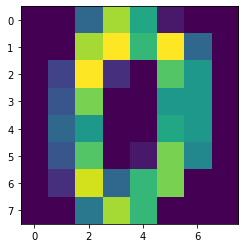

In [5]:
imshow(data_sample)

### Model Definition

Output size is equal to the input size, i.e., 64 units.

In [6]:
# Number of diffusion steps.
T = 100

In [7]:
# Won the race against ReLU.
ACTIVATION_FN = torch.nn.SiLU

In [8]:
class EpsTheta(torch.nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T
        self.eps_theta = torch.nn.Sequential(
            torch.nn.Linear(in_features=IMG_DIM+1, out_features=512),
            ACTIVATION_FN(),
            torch.nn.Linear(in_features=512, out_features=512),
            ACTIVATION_FN(),
            torch.nn.Linear(in_features=512, out_features=512),
            ACTIVATION_FN(),
            torch.nn.Linear(in_features=512, out_features=IMG_DIM))
        
    def forward(self, img: Tensor, t: int) -> Tensor:
        """img is a flat vector (possibly batched), t is a scalar"""
        t_scaled = self._scale_t(t)
        model_input = torch.concat([img, t_scaled], axis=-1)
        model_output = self.eps_theta(model_input)
        return model_output
    
    def _scale_t(self, t: int) -> Tensor:
        return torch.tensor([(t / self.T - 0.5) * 2])

In [9]:
eps_theta = EpsTheta(T=T)

Analyzing the deep image prior...

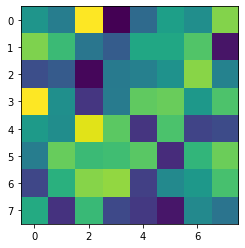

In [10]:
y = eps_theta(img=data_sample, t=0)
imshow(y.detach())

Paper values: $\beta_1=10^{-4}$ and $\beta_T=0.02$

In [11]:
beta_1 = 4.5e-5
beta_T = beta_1 * 20

In [12]:
beta_t = torch.linspace(beta_1, beta_T, T)
alpha_t = 1 - beta_t
alpha_bar_t = torch.tensor([torch.prod(alpha_t[:s]) for s in range(1, T+1)])

def beta(t: int) -> float:
    assert 0 < t <= T
    return beta_t[t-1]

def alpha(t: int) -> float:
    assert 0 < t <= T
    return alpha_t[t-1]

def alpha_bar(t: int) -> float:
    if t == 0: return alpha_bar_t[0]
    assert 0 < t <= T
    return alpha_bar_t[t-1]

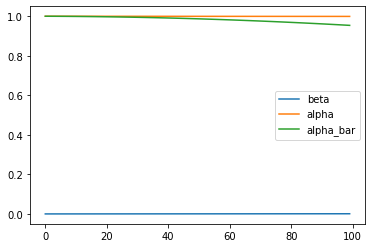

In [13]:
plt.plot(beta_t, label='beta')
plt.plot(alpha_t, label='alpha')
plt.plot(alpha_bar_t, label='alpha_bar')
plt.legend();

### Diffusion Process

(Aka. nosification.) **Eq. (4)** – the closed for of the iterative version in Eq. (2).

In [14]:
def q(x_0: Tensor, t: int) -> Tensor:
    """Implementatin of Eq. (4)."""
    std_normal = torch.randn(x_0.shape)
    mean = torch.sqrt(alpha_bar(t)) * x_0
    var = 1 - alpha_bar(t)
    return mean + std_normal * var.sqrt()

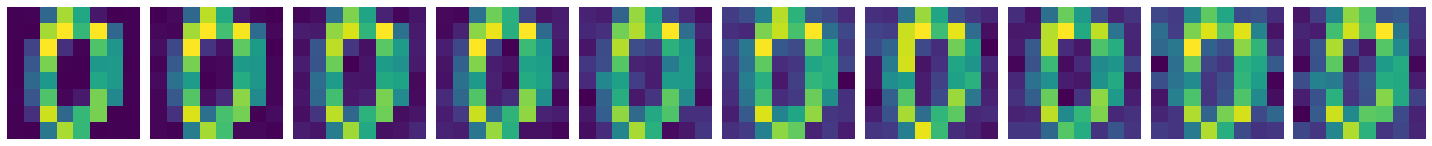

In [15]:
fig, ax = plt.subplots(1, 10, figsize=(20, 8))
ax = ax.flatten()

for i, t in enumerate(range(1, T, T // 10)):
    x_t = q(data_sample, t)
    
    ax[i].imshow(x_t.reshape((8, 8)))
    ax[i].axis('off')

plt.tight_layout()

### Loss Definition

**Eq. (12)** / **Algorithm 1 line 5**

In [16]:
def train_loss(x_0: Tensor, t: int) -> Tensor:
    eps = torch.randn(x_0.shape)
    model_arg = alpha_bar(t).sqrt() * x_0 + (1 - alpha_bar(t)).sqrt() * eps
    eps_model_pred = eps_theta(img=model_arg, t=t)
    return torch.linalg.norm(eps - eps_model_pred) ** 2

### Training

In [17]:
NUM_EPOCHS = 20000
LR = 0.002

torch.manual_seed(124)
eps_theta = EpsTheta(T=T)

# Important update of Adam's beta_2 (might not work otherwise). ;-)
opt = torch.optim.Adam(eps_theta.parameters(), lr=LR, betas=(0.9, 0.996))
ll = []

for epoch in tqdm(range(1, NUM_EPOCHS+1)):
    opt.zero_grad()
        
    loss = torch.tensor(0.)
    for x_0 in data:
        t = torch.randint(1, T+1, size=(1,))
        loss += train_loss(x_0, t.item())
        
    loss /= len(data)
    loss.backward()
    opt.step()
        
    ll.append(loss.detach().item())

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [2:13:30<00:00,  2.50it/s]


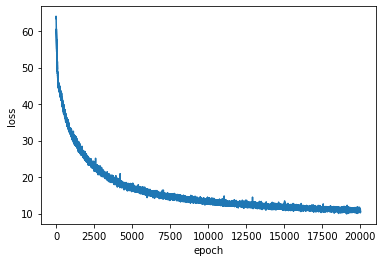

In [18]:
plt.plot(ll)
plt.xlabel('epoch')
plt.ylabel('loss');

### Inference

**Algorithm 2 (Sampling)** (now predicting $\epsilon$)

In [19]:
normal = lambda: torch.randn(data_sample.shape)

def sample():
    # line 1
    x_T = normal()
    x_i = x_T
    
    x_i_list = [x_T]
    plots = defaultdict(list)
    
    for i, t in tqdm(enumerate(range(T, 0, -1))):
        # line 3
        z = normal() if t > 1 else torch.zeros_like(data_sample)
        
        # line 4
        fac1 = 1 / alpha(t).sqrt()
        model_out = eps_theta(x_i, t)
        model_out_fac = (1 - alpha(t)) / (1 - alpha_bar(t)).sqrt()
        fac2 = x_i - model_out_fac * model_out
        sigma_t = beta(t).sqrt()
        x_i = fac1 * fac2 + sigma_t * z
        
        plots['sigma_t_times_z'].append(torch.linalg.norm(sigma_t * z).detach())
        plots['model_out_norm'].append(torch.linalg.norm(model_out).detach())
        plots['x_i_norm'].append(torch.linalg.norm(x_i).detach())
        plots['model_out_factor'].append(model_out_fac.detach())
        x_i_list.append(x_i.detach())
        
    x_0 = x_i
    return x_i_list, plots # line 6

In [20]:
x_i_list, plots = sample()
x_i_sublist = x_i_list[::10]

100it [00:00, 1927.38it/s]


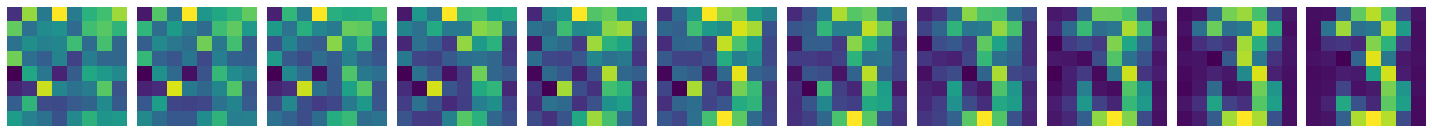

In [21]:
fig, ax = plt.subplots(1, len(x_i_sublist), figsize=(20, 8))
ax = ax.flatten()

for i, x_i in enumerate(x_i_sublist):
    ax[i].imshow(x_i.view((8, 8)))
    ax[i].axis('off')

plt.tight_layout()

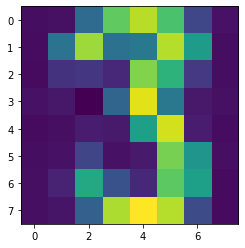

In [22]:
imshow(x_i_list[-1])

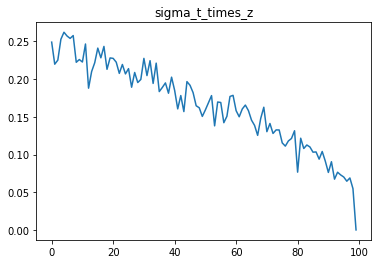

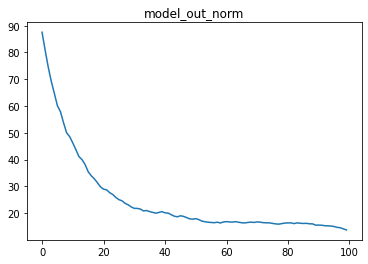

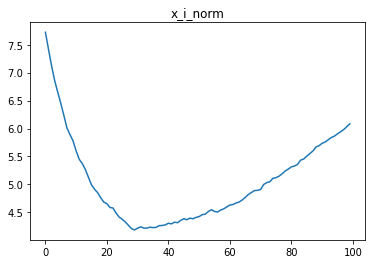

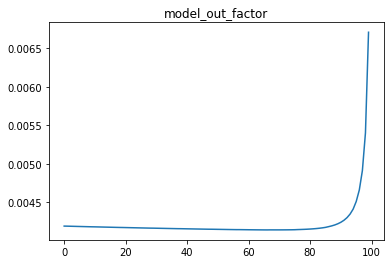

In [23]:
for k, series in plots.items():
    plt.figure()
    plt.plot(series)
    plt.title(k);

## Sample Inspection

100it [00:00, 8939.08it/s]
100it [00:00, 8919.88it/s]
100it [00:00, 8979.07it/s]
100it [00:00, 8921.39it/s]
100it [00:00, 8784.99it/s]
100it [00:00, 7549.42it/s]
100it [00:00, 8784.99it/s]
100it [00:00, 8764.43it/s]
100it [00:00, 9174.50it/s]
100it [00:00, 9242.83it/s]


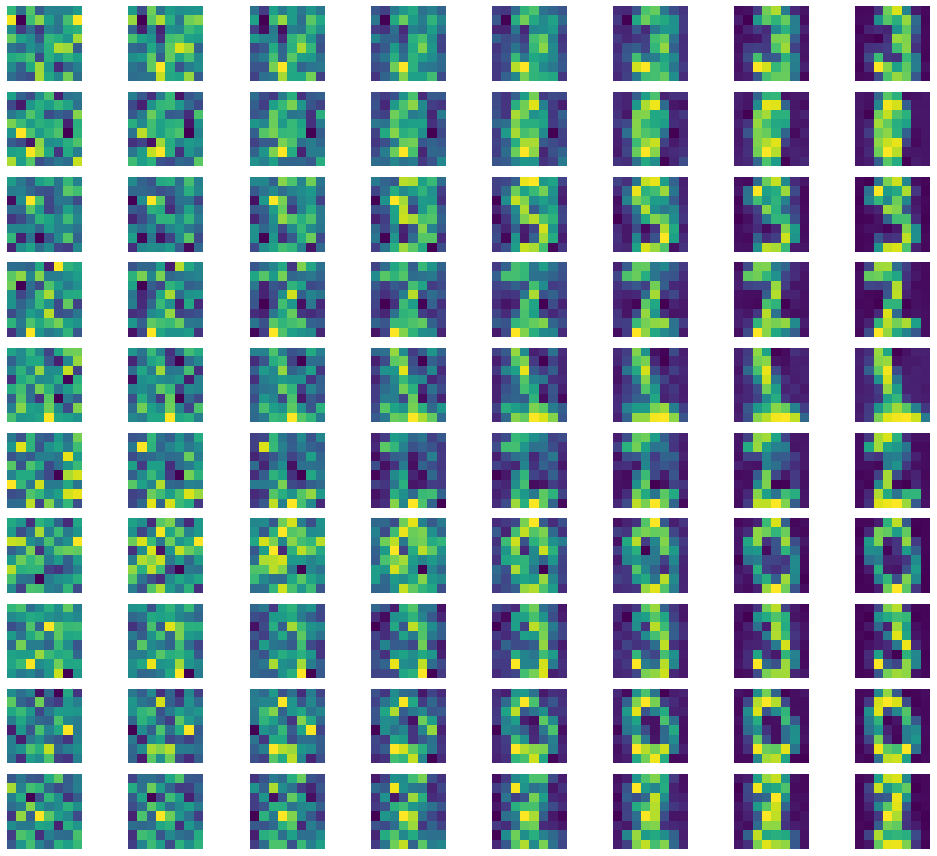

In [24]:
sample_histories = []
for _ in range(10):
    gen_hist, _ = sample()
    sample_histories.append(gen_hist[::15] + [gen_hist[-1]])

fig, ax = plt.subplots(len(sample_histories), len(sample_histories[0]), figsize=(14, 12))

for i, sample_hist in enumerate(sample_histories):
    for j, x_i in enumerate(sample_hist):
        ax[i,j].imshow(x_i.view((8, 8)))
        ax[i,j].axis('off')
        
plt.tight_layout()

## Hparam Optimization

Nothing works so we have to tune hparams in hope that they cause the trouble.

**Algo** hparams:

* Network architecture (num hidden layers, num units)
* $\beta_1$, $\beta_T$
* $T$

**Training** hparams:

* Num epochs, learning rate
* Optimizer (Adam or SGD)

We cannot use the loss as an objective, because it can be lowered through hparams without quality increase.

In [25]:
data.shape

torch.Size([720, 64])

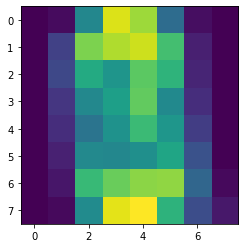

In [26]:
data_mean = torch.mean(data, axis=0)
imshow(data_mean)

In [27]:
def quality_assessment():
    x_i_list, _ = sample()
    x_gen = x_i_list[-1]
    return torch.linalg.norm(x_gen - data_mean)

In [28]:
quality_assessment()

100it [00:00, 9041.59it/s]


tensor(2.6073)